# Assignment 2 - Classification

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import importlib
from Utils.Funcs import *
from scipy import stats
from scipy.special import expit

## Question 2 - Part 1 (Naive Bayes Classifier)

In [2]:
X_train = pd.read_csv("Data/X_train.csv", header = None).values
X_test = pd.read_csv("Data/X_test.csv", header = None).values
Y_train = pd.read_csv("Data/y_train.csv", header = None).values
Y_test = pd.read_csv("Data/y_test.csv", header = None).values

In [3]:
X_0 = X_train[(Y_train==0).reshape(Y_train.shape[0]), :]
X_1 = X_train[(Y_train==1).reshape(Y_train.shape[0]), :]

### Prediction

In [4]:
k = X_train.shape[1]

theta_0 = [calc_bernoulli(X_0[:,i]) if i < 54 else calc_pareto(X_0[:,i]) for i in range(k)]
theta_1 = [calc_bernoulli(X_1[:,i]) if i < 54 else calc_pareto(X_1[:,i]) for i in range(k)]

In [5]:
pi_pred = np.mean(Y_test)
N = X_test.shape[0]y_hat
y_pred = [calc_bayes(theta_0 = theta_0, theta_1 = theta_1, X_test = X_test[i, :], pi_pred = pi_pred) for i in range(N)]

In [6]:
y_pred = list(map(int, y_pred))
y_actual = Y_test.reshape(Y_test.shape[0]).tolist()
y_pred_df = pd.DataFrame({'Actual': y_actual, 'Predicted' : y_pred})
pd.crosstab(y_pred_df['Actual'], y_pred_df['Predicted'])

Predicted,0,1
Actual,,
0,55,1
1,6,31


Based on the confusion matrix above, the naive Bayes model gives us an accuracy of $ (55+31)/(55+31+6+1) \approx 92\% $.

### Examining Weights

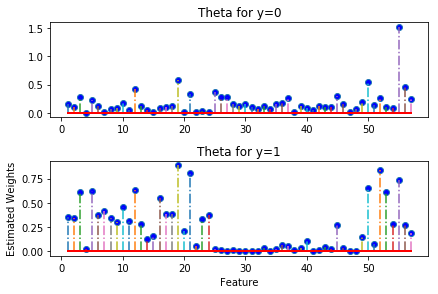

In [7]:
plot_nbayes(weight_0 = theta_0, weight_1 = theta_1)

The different distributions of the weights conditional on the class (spam or not spam) illustrate how the naive Bayes looks as conditional likleihood.

## Question 2 - Part 2 (K-nn classifier)

In [8]:
np.random.seed(123456)
N = X_test.shape[0]

y_pred = [[K_nn(X_train, Y_train, X_test[i,:], k = k) for i in range(N)] for k in range(1,21)]

In [9]:
names = ["k = " + str(i) for i in range(1,21)]
y_pred_dict = {names[i]: y_pred[i] for i in range(20)}
y_pred_df = pd.DataFrame(y_pred_dict)
Accuracy = []
K = y_pred_df.shape[1]
for i in range(K):
    Accuracy.append(np.sum(y_pred_df.iloc[:,i] == Y_test.reshape(Y_test.shape[0])) / Y_test.shape[0])

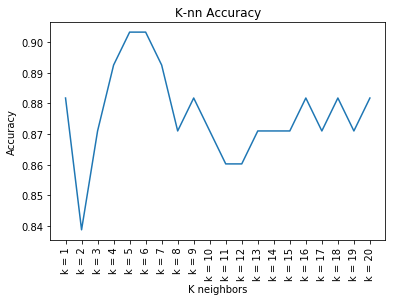

In [10]:
plt.plot(names, Accuracy)
plt.xticks(rotation='vertical')
plt.xlabel("K neighbors")
plt.ylabel("Accuracy")
plt.title("K-nn Accuracy")
plt.show()

Based on the graph above it seems as if the best number of k-neighbors is around 5-6. Although the highest accuracy reached is around $ 90 \% $.

## Question 2 - Part 3 (Logistic Regression)

In [39]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()
Y_train2 = Y_train.copy()
Y_test2 = Y_test.copy()

In [40]:
N_train = X_train2.shape[0]
N_test = X_test2.shape[0]

X_train2 = np.column_stack((X_train2, np.ones((N_train,1))))
X_test2 = np.column_stack((X_test2, np.ones((N_test,1))))

k = X_train2.shape[1]

Y_train2[Y_train2 == 0] = -1
Y_test2[Y_test2 == 0] = -1

### SDG

In [13]:
W, Accuracy_tr, liklihood = logistic_fit(X_train = X_train2, Y_train = Y_train2, Iter = 10000, method = "SDG")
Iterations = np.arange(10000)

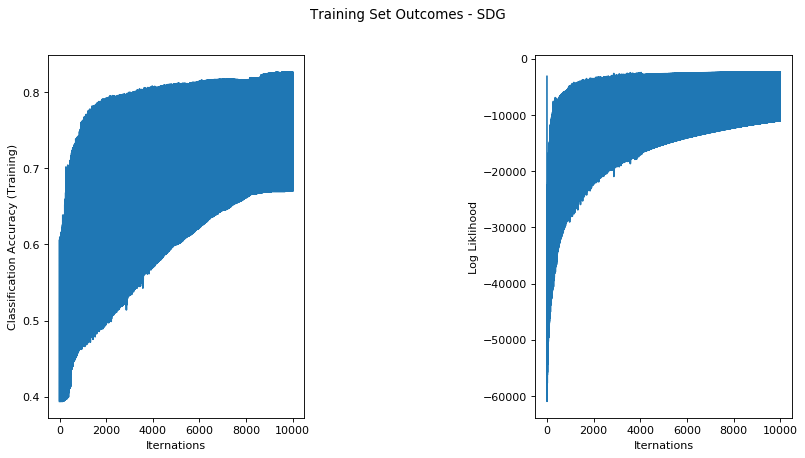

In [18]:
plt.figure(1, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.suptitle("Training Set Outcomes - SDG")
plt.subplots_adjust(hspace=0.9, wspace=0.9)
plt.subplot(1,2,1)
plt.plot(Iterations, Accuracy_tr)
plt.ylabel("Classification Accuracy (Training)")
plt.xlabel("Iternations")
plt.subplot(1,2,2)
plt.plot(Iterations, liklihood)
plt.ylabel("Log Liklihood")
plt.xlabel("Iternations")
plt.show()

### Newton's Method

In [15]:
W_n, Accuracy_tr_n, liklihood_n = logistic_fit(X_train = X_train2, Y_train = Y_train2, Iter = 100, method = "Newton")
Iterations_n = np.arange(100)

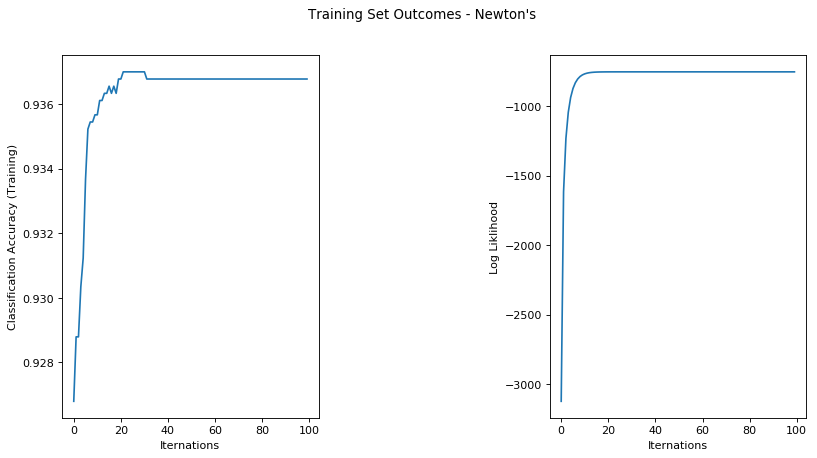

In [19]:
plt.figure(1, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.suptitle("Training Set Outcomes - Newton's")
plt.subplots_adjust(hspace=0.9, wspace=0.9)
plt.subplot(1,2,1)
plt.plot(Iterations_n, Accuracy_tr_n)
plt.ylabel("Classification Accuracy (Training)")
plt.xlabel("Iternations")
plt.subplot(1,2,2)
plt.plot(Iterations_n, liklihood_n)
plt.ylabel("Log Liklihood")
plt.xlabel("Iternations")
plt.show()

Comparing the two sets of charts, it is clear that the Newton's method works much better than (and seems to converge) the SDG as we implemented it, and it does so in much less iterations (100 vs 10000). next we turn to performance on the testing set.

### Prediction

In [44]:
logistic_predict(X_test = X_test2, Y_test = Y_test2, W = W)

0.6881720430107527

In [45]:
logistic_predict(X_test = X_test2, Y_test = Y_test2, W = W_n)

0.9139784946236559

The test set classification accuracy of the logistic after 10000 iterations using standard sdg is about $ 68.8 \% $, whereas the accuracy with Newton's method is about $ 91.4 \% $ which is comparable to the naive bayes model, and better than the k-nn.

## Comparing with scikit-learn

### Naive Bayes

In [120]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [61]:
Y_train_scikit = Y_train.reshape(Y_train.shape[0])
Y_test_scikit = Y_test.reshape(Y_test.shape[0])

We have to do a workaround here because the standard scikit learn package doesnt allow for a naive bayes to fit on a set os festures with different distributions, so we split into binomial and multinomial, stack the probabilites and then use a gaussian.

In [103]:
clf = BernoulliNB()
clf.fit(X = X_train, y = Y_train_scikit)
y_pred = clf.predict(X_test)
y_pred_df = pd.DataFrame({'Actual': y_actual, 'Predicted' : y_pred})
pd.crosstab(y_pred_df['Actual'], y_pred_df['Predicted'])

Predicted,0,1
Actual,,
0,53,3
1,4,33


In [104]:
clf = MultinomialNB()
clf.fit(X = X_train, y = Y_train_scikit)
y_pred = clf.predict(X_test)
y_pred_df = pd.DataFrame({'Actual': y_actual, 'Predicted' : y_pred})
pd.crosstab(y_pred_df['Actual'], y_pred_df['Predicted'])

Predicted,0,1
Actual,,
0,40,16
1,8,29


In [105]:
clf = GaussianNB()
clf.fit(X = X_train, y = Y_train_scikit)
y_pred = clf.predict(X_test)
y_pred_df = pd.DataFrame({'Actual': y_actual, 'Predicted' : y_pred})
pd.crosstab(y_pred_df['Actual'], y_pred_df['Predicted'])

Predicted,0,1
Actual,,
0,53,3
1,4,33


The Gaussian and Binomial models period quite well, both achieving $ (53+43) / (53+43+3+4) = 93.1 \% $ which is higher than the made from scratch version above. This is likely becasue the probability parameters have been better estimated through teh automatic scikit-learn algo.

### K-nn Classifier

In [112]:
Iters = np.arange(1,21)
Scores = []
for i in range(1, 21):
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(X = X_train, y = Y_train_scikit)
    clf.predict(X_test)
    score = clf.score(X = X_test, y = Y_test)
    Scores.append(score)

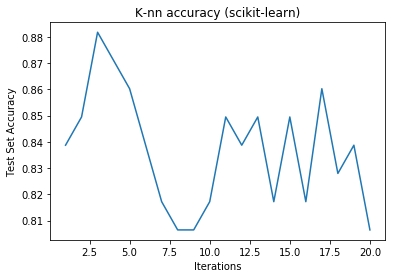

In [117]:
plt.plot(Iters, Scores)
plt.xlabel("Iterations")
plt.ylabel("Test Set Accuracy")
plt.title("K-nn accuracy (scikit-learn)")
plt.show()

The highest accuracy reached is around $ 88 \% $ at k = 3, which is lower and a different k parameter than what the made from scratch model suggested.

### Logistic Regression

In [126]:
clf = LogisticRegression(penalty = 'l2', C = 1e9, solver = 'newton-cg')
clf.fit(X = X_train, y = Y_train_scikit)
clf.predict(X_test)
clf.score(X = X_test, y = Y_test_scikit)

0.9139784946236559

In [130]:
clf = LogisticRegression(penalty = 'l2', C = 0.3, solver = 'newton-cg')
clf.fit(X = X_train, y = Y_train_scikit)
clf.predict(X_test)
clf.score(X = X_test, y = Y_test_scikit)

0.9354838709677419

The top classifier resembles the one we implemented using the newton method and acheievs a similar accuracy. In the bottom classifier we add some regulizarization in the form of a L2 penalty and see the performance of the model rise to about $ 93.5 \% $

## OOC Examples

In [1]:
from Utils.OOC import *

Number of features: 57
Training sample: 4508
Testing sample: 93
Predicted   0   1
Actual           
0          55   1
1           6  31


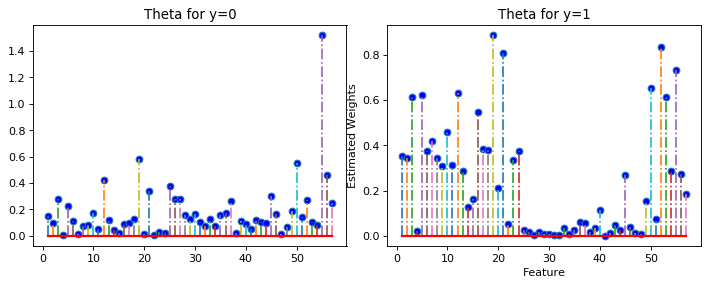

None


In [2]:
Custom_model = NaiveBayes('Custom', ["X_test", "X_train", "y_test", "y_train"], 
                          bernoulli_cols = [0,54], pareto_cols = [54,58])
Custom_model.make_array()
Custom_model.get_shape()
Custom_model.conditional_split()
Custom_model.fit()
Custom_model.predict()
Custom_model.conf_matrix()
Custom_model.plot_weights(dims = (9, 3.5))

In [26]:
Scikit_model = NaiveBayes('scikit', ["X_test", "X_train", "y_test", "y_train"], 
                          bernoulli_cols = [0,54], pareto_cols = [54,58], use_custom = False)
Scikit_model.make_array()
Scikit_model.get_shape()
Scikit_model.fit()
Scikit_model.predict()
Scikit_model.conf_matrix()

Number of features: 57
Training sample: 4508
Testing sample: 93
Predicted   0   1
Actual           
0          53   3
1           4  33
